# Implementation LSTM model for Forecasting
### 'My Stock Forecast App'

In [1]:
import yfinance as yf
from datetime import date
import pandas as pd
import numpy as np
from sklearn import metrics
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

## DATA INGESTION

In [3]:
# Input dari pengguna untuk simbol saham
symbol = input("Input simbol saham (e.g 'BBRI.JK'): ")
start_date = date(2019, 1, 1)
end_date = date(2024, 2, 1)

# Mengunduh data saham dari Yahoo Finance
data = yf.download(symbol, start=start_date, end=end_date)

c:\Users\kevin\miniconda3\envs\tf\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [4]:
data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-01,3327.215332,3327.215332,3327.215332,3327.215332,2594.004150,0
2019-01-02,3281.761475,3309.033691,3263.580078,3281.761475,2558.566650,82441033
2019-01-03,3254.489258,3309.033691,3254.489258,3290.852295,2565.653809,102805905
2019-01-04,3290.852295,3327.215332,3281.761475,3327.215332,2594.004150,125907734
2019-01-07,3363.578369,3372.668945,3327.215332,3327.215332,2594.004150,82106628


In [5]:
data.reset_index(inplace=True)

# Input dari pengguna untuk fitur yang akan digunakan
input_feat = input("Input feature yang akan digunakan (e.g: Open, High, Low, Close, Adj Close, Volume): ")

# Memilih kolom tanggal dan fitur yang akan digunakan
data = data[["Date", input_feat]]
print(data.shape)
data

(1254, 2)


,Date,Close
0,2019-01-01,3327.215332
1,2019-01-02,3281.761475
2,2019-01-03,3290.852295
3,2019-01-04,3327.215332
4,2019-01-07,3327.215332
...,...,...
1249,2024-01-25,5525.000000
1250,2024-01-26,5425.000000
1251,2024-01-29,5575.000000
1252,2024-01-30,5625.000000


## DATA PROCESSING

In [6]:
# Melakukan scaling feature
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[input_feat].values.reshape(-1, 1))

# print(scaled_data)
# print(dir(scaled_data))

In [7]:
# Pembagian data menjadi data training dan data testing
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size, :], scaled_data[train_size:, :]

print(train_data)
print(train_data.shape)
# print(dir(train_data))

print(test_data)
print(test_data.shape)
print(train_size)

[[0.34934613]
 [0.33762308]
 [0.3399677 ]
 ...
 [0.62087085]
 [0.65182017]
 [0.64666195]]
(1003, 1)
[[0.65697839]
 [0.66729483]
 [0.67761127]
 [0.68019038]
 [0.69050682]
 [0.68276949]
 [0.66729483]
 [0.67503216]
 [0.68792771]
 [0.68019038]
 [0.67245305]
 [0.69824415]
 [0.67761127]
 [0.71629792]
 [0.71371881]
 [0.71629792]
 [0.72661436]
 [0.73177258]
 [0.74466813]
 [0.72919347]
 [0.74724724]
 [0.74724724]
 [0.74724724]
 [0.74982635]
 [0.74982635]
 [0.73435169]
 [0.71887703]
 [0.72919347]
 [0.71887703]
 [0.73177258]
 [0.69566504]
 [0.70856059]
 [0.72403525]
 [0.71887703]
 [0.72661436]
 [0.73950991]
 [0.73950991]
 [0.73177258]
 [0.73435169]
 [0.7369308 ]
 [0.70598148]
 [0.70340237]
 [0.7111397 ]
 [0.75498457]
 [0.74982635]
 [0.75498457]
 [0.72145614]
 [0.71371881]
 [0.72145614]
 [0.73177258]
 [0.71629792]
 [0.7111397 ]
 [0.72919347]
 [0.73435169]
 [0.7369308 ]
 [0.73950991]
 [0.74466813]
 [0.74982635]
 [0.7627219 ]
 [0.77561744]
 [0.80011899]
 [0.77819655]
 [0.76788011]
 [0.78722344]
 [0.

In [8]:
# Persiapan data untuk model LSTM
def create_sequences(data, sequence_length):
    sequences = []
    target = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        target.append(data[i+sequence_length])
    return np.array(sequences), np.array(target)

In [9]:
tf.random.set_seed(7)

In [10]:
sequence_length = 10 
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

input_dim_size = 10000
embedding_dim_size = 100 


# Modelling

In [11]:
# Membangun model LSTM
model = Sequential()
model.add(Embedding(input_dim=input_dim_size, output_dim=embedding_dim_size, input_length=sequence_length))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='relu'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 100)           1000000   
                                                                 
 lstm (LSTM)                 (None, 10, 128)           117248    
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

In [12]:
# Kompilasi dan pelatihan model
cp3 = ModelCheckpoint('../model/model2/', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)


optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error'])
model_final = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=2, callbacks=[cp3, early_stopping], validation_data=(X_test, y_test))

Epoch 1/100


INFO:tensorflow:Assets written to: ../model/model2\assets


INFO:tensorflow:Assets written to: ../model/model2\assets


16/16 - 15s - loss: 0.0981 - mean_absolute_error: 0.2558 - val_loss: 0.1878 - val_mean_absolute_error: 0.4250 - 15s/epoch - 931ms/step
Epoch 2/100


INFO:tensorflow:Assets written to: ../model/model2\assets


INFO:tensorflow:Assets written to: ../model/model2\assets


16/16 - 8s - loss: 0.0316 - mean_absolute_error: 0.1416 - val_loss: 0.1629 - val_mean_absolute_error: 0.3946 - 8s/epoch - 484ms/step
Epoch 3/100


INFO:tensorflow:Assets written to: ../model/model2\assets


INFO:tensorflow:Assets written to: ../model/model2\assets


16/16 - 9s - loss: 0.0290 - mean_absolute_error: 0.1360 - val_loss: 0.1450 - val_mean_absolute_error: 0.3712 - 9s/epoch - 533ms/step
Epoch 4/100


INFO:tensorflow:Assets written to: ../model/model2\assets


INFO:tensorflow:Assets written to: ../model/model2\assets


16/16 - 8s - loss: 0.0284 - mean_absolute_error: 0.1327 - val_loss: 0.1427 - val_mean_absolute_error: 0.3682 - 8s/epoch - 517ms/step
Epoch 5/100
16/16 - 0s - loss: 0.0289 - mean_absolute_error: 0.1357 - val_loss: 0.1609 - val_mean_absolute_error: 0.3921 - 370ms/epoch - 23ms/step
Epoch 6/100
16/16 - 0s - loss: 0.0274 - mean_absolute_error: 0.1323 - val_loss: 0.1532 - val_mean_absolute_error: 0.3821 - 230ms/epoch - 14ms/step
Epoch 7/100
16/16 - 0s - loss: 0.0278 - mean_absolute_error: 0.1309 - val_loss: 0.1640 - val_mean_absolute_error: 0.3960 - 252ms/epoch - 16ms/step
Epoch 8/100
16/16 - 0s - loss: 0.0276 - mean_absolute_error: 0.1313 - val_loss: 0.1605 - val_mean_absolute_error: 0.3915 - 240ms/epoch - 15ms/step
Epoch 9/100


INFO:tensorflow:Assets written to: ../model/model2\assets


INFO:tensorflow:Assets written to: ../model/model2\assets


16/16 - 8s - loss: 0.0282 - mean_absolute_error: 0.1328 - val_loss: 0.1210 - val_mean_absolute_error: 0.3374 - 8s/epoch - 477ms/step
Epoch 10/100
16/16 - 0s - loss: 0.0280 - mean_absolute_error: 0.1322 - val_loss: 0.1479 - val_mean_absolute_error: 0.3752 - 426ms/epoch - 27ms/step
Epoch 11/100
16/16 - 0s - loss: 0.0265 - mean_absolute_error: 0.1301 - val_loss: 0.1517 - val_mean_absolute_error: 0.3802 - 246ms/epoch - 15ms/step
Epoch 12/100
16/16 - 0s - loss: 0.0271 - mean_absolute_error: 0.1305 - val_loss: 0.1482 - val_mean_absolute_error: 0.3755 - 267ms/epoch - 17ms/step
Epoch 13/100
16/16 - 0s - loss: 0.0281 - mean_absolute_error: 0.1318 - val_loss: 0.1384 - val_mean_absolute_error: 0.3622 - 230ms/epoch - 14ms/step
Epoch 14/100
16/16 - 0s - loss: 0.0278 - mean_absolute_error: 0.1316 - val_loss: 0.1529 - val_mean_absolute_error: 0.3817 - 241ms/epoch - 15ms/step
Epoch 15/100
16/16 - 0s - loss: 0.0275 - mean_absolute_error: 0.1322 - val_loss: 0.1416 - val_mean_absolute_error: 0.3666 - 243

INFO:tensorflow:Assets written to: ../model/model2\assets


INFO:tensorflow:Assets written to: ../model/model2\assets


16/16 - 9s - loss: 0.0284 - mean_absolute_error: 0.1336 - val_loss: 0.1162 - val_mean_absolute_error: 0.3303 - 9s/epoch - 536ms/step
Epoch 17/100


INFO:tensorflow:Assets written to: ../model/model2\assets


INFO:tensorflow:Assets written to: ../model/model2\assets


16/16 - 8s - loss: 0.0270 - mean_absolute_error: 0.1293 - val_loss: 0.1142 - val_mean_absolute_error: 0.3273 - 8s/epoch - 500ms/step
Epoch 18/100
16/16 - 0s - loss: 0.0260 - mean_absolute_error: 0.1285 - val_loss: 0.1359 - val_mean_absolute_error: 0.3589 - 424ms/epoch - 26ms/step
Epoch 19/100
16/16 - 0s - loss: 0.0260 - mean_absolute_error: 0.1282 - val_loss: 0.1392 - val_mean_absolute_error: 0.3634 - 258ms/epoch - 16ms/step
Epoch 20/100
16/16 - 0s - loss: 0.0270 - mean_absolute_error: 0.1305 - val_loss: 0.1682 - val_mean_absolute_error: 0.4014 - 270ms/epoch - 17ms/step
Epoch 21/100
16/16 - 0s - loss: 0.0262 - mean_absolute_error: 0.1287 - val_loss: 0.1657 - val_mean_absolute_error: 0.3982 - 274ms/epoch - 17ms/step
Epoch 22/100
16/16 - 0s - loss: 0.0267 - mean_absolute_error: 0.1276 - val_loss: 0.1970 - val_mean_absolute_error: 0.4358 - 280ms/epoch - 18ms/step
Epoch 23/100
16/16 - 0s - loss: 0.0287 - mean_absolute_error: 0.1353 - val_loss: 0.1699 - val_mean_absolute_error: 0.4035 - 248

# Evaluation

In [13]:
# Evaluasi model pada data uji
loss = model.evaluate(X_test, y_test)
round_loss = [round(num, 5) for num in loss]
print("Loss :", round_loss)

predict = model.predict(X_test)
# print(predict)

8/8 [==============================] - 0s 6ms/step - loss: 0.1142 - mean_absolute_error: 0.3273
Loss : [0.11423, 0.32725]
8/8 [==============================] - 1s 5ms/step


In [14]:
print("-"*15, " Metric ","-"*15)
print('RMSE : ', round(sqrt(metrics.mean_squared_error(y_test, predict)), 5))
print('MSE  : ', round(abs(metrics.mean_squared_error(y_test, predict)), 5))
print('MAE  : ', round(metrics.mean_absolute_error(y_test, predict), 5))

---------------  Metric  ---------------
RMSE :  0.33798
MSE  :  0.11423
MAE  :  0.32725


# Visualization

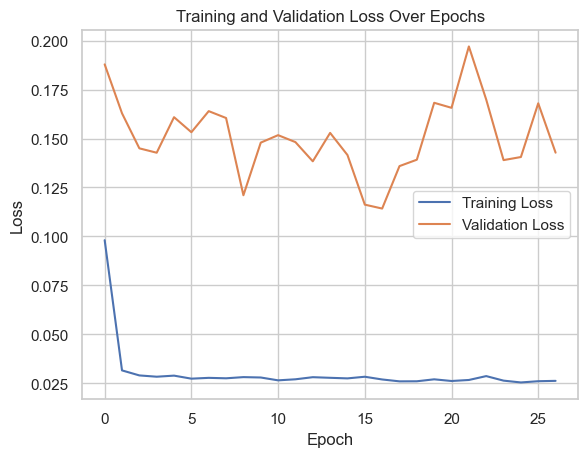

In [15]:
# Plot loss
sns.set(style="whitegrid")

sns.lineplot(x=range(len(model_final.history['loss'])), y=model_final.history['loss'], label='Training Loss')
sns.lineplot(x=range(len(model_final.history['val_loss'])), y=model_final.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Saving Model

In [16]:
import time

ts = int(time.time())
file_path = f"../lstm_stock/{ts}/"
model.save(filepath=file_path, save_format='tf')
# model.save("../lstm_model3.keras")
print("Sucess saving model!")

INFO:tensorflow:Assets written to: ../lstm_stock/1713643381/assets


INFO:tensorflow:Assets written to: ../lstm_stock/1713643381/assets


Sucess saving model!
